# 02 — Exploratory Data Analysis: Cleaned GBIF Data

**Objective**: Analyze cleaned GBIF shark occurrence data with spatial/temporal aggregation for NSSM/DMM framework.

**Data sources**:
1. **GBIF occurrences** — Cleaned shark + marine species (2010-2023)
2. **Sea Surface Temperature (SST)** — NOAA OISST v2.1 (monthly)
3. **Fishing effort** — Global Fishing Watch (2020-2024)

**Region**: Brazilian coast (-35°S to 5°N, -50°W to -30°W)

**Resolution**: 
- Spatial: 2° × 2° grid (200 cells)
- Temporal: Quarterly aggregation (56 timesteps)

**Target species**: 
- *Galeocerdo cuvier* (Tiger shark) — 23 records
- *Carcharhinus longimanus* (Oceanic whitetip) — 6 records

In [1]:
# =============================================================================
# SETUP: Configuration & Imports
# =============================================================================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
project_root = Path.cwd().parent
data_dir = project_root / "data"
processed_dir = data_dir / "processed"

# Grid configuration (optimized from feasibility study)
GRID_RES = 2.0  # degrees
LAT_MIN, LAT_MAX = -35, 5
LON_MIN, LON_MAX = -50, -30
N_LAT = int((LAT_MAX - LAT_MIN) / GRID_RES)
N_LON = int((LON_MAX - LON_MIN) / GRID_RES)
N_SPATIAL = N_LAT * N_LON

print(f"🗺️  Grid Configuration:")
print(f"   Spatial: {GRID_RES}°×{GRID_RES}° → {N_SPATIAL} cells ({N_LAT}×{N_LON})")
print(f"   Region: {LAT_MIN}° to {LAT_MAX}°N, {LON_MIN}° to {LON_MAX}°E")
print(f"   Temporal: Quarterly (2010-2023)")

🗺️  Grid Configuration:
   Spatial: 2.0°×2.0° → 200 cells (20×10)
   Region: -35° to 5°N, -50° to -30°E
   Temporal: Quarterly (2010-2023)


## 1. Load Cleaned GBIF Data (Parquet Format)

**Data**: 539 clean records after filtering
- Spatial: within study region
- Temporal: 2010-2023
- Quality: duplicates removed, coordinates validated

In [2]:
# Load cleaned GBIF data (Parquet format)
gbif_path = processed_dir / "gbif_cleaned.parquet"
summary_path = processed_dir / "gbif_spatiotemporal_summary.parquet"

print(f"📂 Loading data...")
df_gbif = pd.read_parquet(gbif_path)
df_summary = pd.read_parquet(summary_path)

print(f"\n✅ Loaded successfully!")
print(f"\n📊 Full Dataset:")
print(f"   Records: {len(df_gbif):,}")
print(f"   Columns: {len(df_gbif.columns)}")
print(f"   Memory: {df_gbif.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"   Date range: {df_gbif['year'].min():.0f}-{df_gbif['year'].max():.0f}")
print(f"   Species: {df_gbif['species'].nunique()}")

print(f"\n📋 Spatiotemporal Summary:")
print(f"   Occupied cells: {len(df_summary):,}")
print(f"   Quarters: {df_summary['year_quarter'].nunique()}")
print(f"   Spatial cells: {df_summary['spatial_cell_id'].nunique()}")

print(f"\n🦈 Target Sharks:")
target_counts = df_gbif[df_gbif['is_target_shark']].groupby('target_species_name').size()
for species, count in target_counts.items():
    if species != 'Other':
        print(f"   • {species}: {count}")

# Display sample
df_gbif.head()

📂 Loading data...

✅ Loaded successfully!

📊 Full Dataset:
   Records: 539
   Columns: 31
   Memory: 0.57 MB
   Date range: 2010-2023
   Species: 81

📋 Spatiotemporal Summary:
   Occupied cells: 255
   Quarters: 56
   Spatial cells: 47

🦈 Target Sharks:
   • Carcharhinus longimanus: 6
   • Galeocerdo cuvier: 23


,record_id,scientific_name,species,genus,family,order,class_,latitude,longitude,coord_uncertainty_m,...,data_source,lat_cell,lon_cell,quarter,year_quarter,lat_cell_id,lon_cell_id,spatial_cell_id,is_target_shark,target_species_name
0,891169152,"Rhincodon typus Smith, 1828",Rhincodon typus,Rhincodon,Rhincodontidae,Orectolobiformes,Elasmobranchii,-27.111462,-48.539333,29775.0,...,GBIF,-28.0,-50.0,2,2013Q2,3,0,30,False,Other
1,857006932,"Ginglymostoma cirratum (Bonnaterre, 1788)",Ginglymostoma cirratum,Ginglymostoma,Ginglymostomatidae,Orectolobiformes,Elasmobranchii,-8.100470,-34.779900,100.0,...,GBIF,-10.0,-36.0,3,2012Q3,12,7,127,False,Other
2,857006927,"Dasyatis marianae Gomes, Rosa & Gadig, 2000",Hypanus marianae,Hypanus,Dasyatidae,Myliobatiformes,Elasmobranchii,-8.121940,-34.762798,100.0,...,GBIF,-10.0,-36.0,3,2012Q3,12,7,127,False,Other
3,857006923,"Ginglymostoma cirratum (Bonnaterre, 1788)",Ginglymostoma cirratum,Ginglymostoma,Ginglymostomatidae,Orectolobiformes,Elasmobranchii,-8.121940,-34.762798,100.0,...,GBIF,-10.0,-36.0,3,2012Q3,12,7,127,False,Other
4,857006768,"Aetobatus narinari (Euphrasen, 1790)",Aetobatus narinari,Aetobatus,Myliobatidae,Myliobatiformes,Elasmobranchii,-24.318600,-46.178398,100.0,...,GBIF,-26.0,-48.0,3,2012Q3,4,1,41,False,Other


## 2. Species Composition & Diversity

Analyze the taxonomic breakdown and identify top species in the cleaned dataset.

SPECIES COMPOSITION

📊 Summary Statistics:
   Total species: 81
   Total records: 487
   Most common: Hypanus guttatus (48 records)

🔝 Top 20 Species:
    1. Hypanus guttatus                           48 (  8.9%) 
    2. Hypanus berthalutzae                       44 (  8.2%) 
    3. Zapteryx brevirostris                      32 (  5.9%) 
    4. Rioraja agassizii                          25 (  4.6%) 
    5. Ginglymostoma cirratum                     25 (  4.6%) 
    6. Galeocerdo cuvier                          23 (  4.3%) 🦈
    7. Narcine brasiliensis                       20 (  3.7%) 
    8. Hypanus americanus                         18 (  3.3%) 
    9. Pseudobatos horkelii                       14 (  2.6%) 
   10. Pseudobatos percellens                     14 (  2.6%) 
   11. Rhizoprionodon lalandii                    13 (  2.4%) 
   12. Aetobatus narinari                         13 (  2.4%) 
   13. Rhizoprionodon porosus                     12 (  2.2%) 
   14. Hypanus marianae      

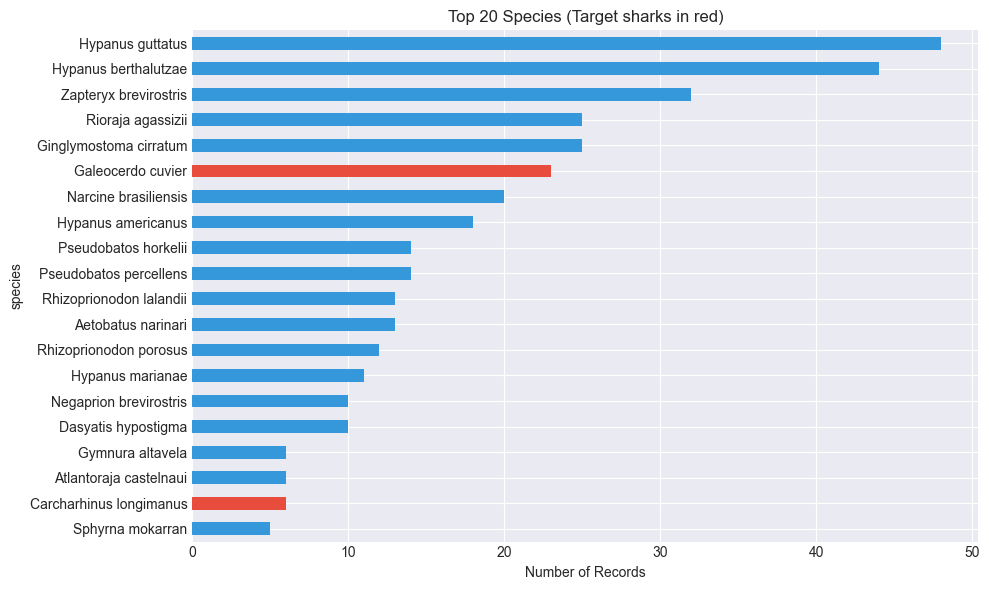

In [3]:
# Species composition
species_counts = df_gbif['species'].value_counts()

print("=" * 80)
print("SPECIES COMPOSITION")
print("=" * 80)

print(f"\n📊 Summary Statistics:")
print(f"   Total species: {len(species_counts)}")
print(f"   Total records: {species_counts.sum():,}")
print(f"   Most common: {species_counts.index[0]} ({species_counts.iloc[0]} records)")

print(f"\n🔝 Top 20 Species:")
for i, (species, count) in enumerate(species_counts.head(20).items(), 1):
    pct = (count / len(df_gbif)) * 100
    is_target = "🦈" if species in ['Galeocerdo cuvier', 'Carcharhinus leucas', 'Carcharhinus longimanus'] else ""
    print(f"   {i:2d}. {species:40s} {count:4d} ({pct:5.1f}%) {is_target}")

# Taxonomic breakdown
print(f"\n🧬 Taxonomic Diversity:")
for level in ['order', 'family', 'genus']:
    if level in df_gbif.columns:
        n_unique = df_gbif[level].nunique()
        print(f"   {level.capitalize()}: {n_unique}")

# Target sharks detail
print(f"\n🦈 Target Shark Analysis:")
target_sharks = df_gbif[df_gbif['is_target_shark']]
print(f"   Total target records: {len(target_sharks)}")
print(f"   Percentage of dataset: {(len(target_sharks)/len(df_gbif))*100:.1f}%")
print(f"\n   Breakdown:")
for species in ['Galeocerdo cuvier', 'Carcharhinus leucas', 'Carcharhinus longimanus']:
    count = (df_gbif['species'] == species).sum()
    if count > 0:
        pct = (count / len(target_sharks)) * 100
        print(f"   • {species}: {count} records ({pct:.1f}% of targets)")

# Visualize top species
fig, ax = plt.subplots(figsize=(10, 6))
top_20 = species_counts.head(20)
colors = ['#e74c3c' if sp in ['Galeocerdo cuvier', 'Carcharhinus leucas', 'Carcharhinus longimanus'] 
          else '#3498db' for sp in top_20.index]
top_20.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Number of Records')
ax.set_title('Top 20 Species (Target sharks in red)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Spatial Distribution

Analyze geographic patterns in the 2°×2° grid.

SPATIAL DISTRIBUTION

📐 Grid Statistics:
   Total grid cells: 200
   Occupied cells: 47
   Coverage: 23.5%

📊 Records per Cell:
   Mean: 11.5
   Median: 7.0
   Max: 77
   Min: 1

🔝 Top 10 Hotspots:
    1. Cell 158 (-4°, -34°):  77 records
    2. Cell  52 (-24°, -46°):  40 records
    3. Cell 127 (-10°, -36°):  36 records
    4. Cell  74 (-20°, -42°):  34 records
    5. Cell  41 (-26°, -48°):  33 records
    6. Cell  53 (-24°, -44°):  32 records
    7. Cell 153 (-4°, -44°):  29 records
    8. Cell  85 (-18°, -40°):  27 records
    9. Cell  54 (-24°, -42°):  20 records
   10. Cell  64 (-22°, -42°):  16 records

🦈 Target Shark Locations:
   Cells with target sharks: 8
   • Galeocerdo cuvier:
     Cells: 4, Lat: -12.3° to -2.4°, Lon: -44.0° to -32.4°
   • Carcharhinus longimanus:
     Cells: 4, Lat: -3.6° to -0.4°, Lon: -38.0° to -30.9°


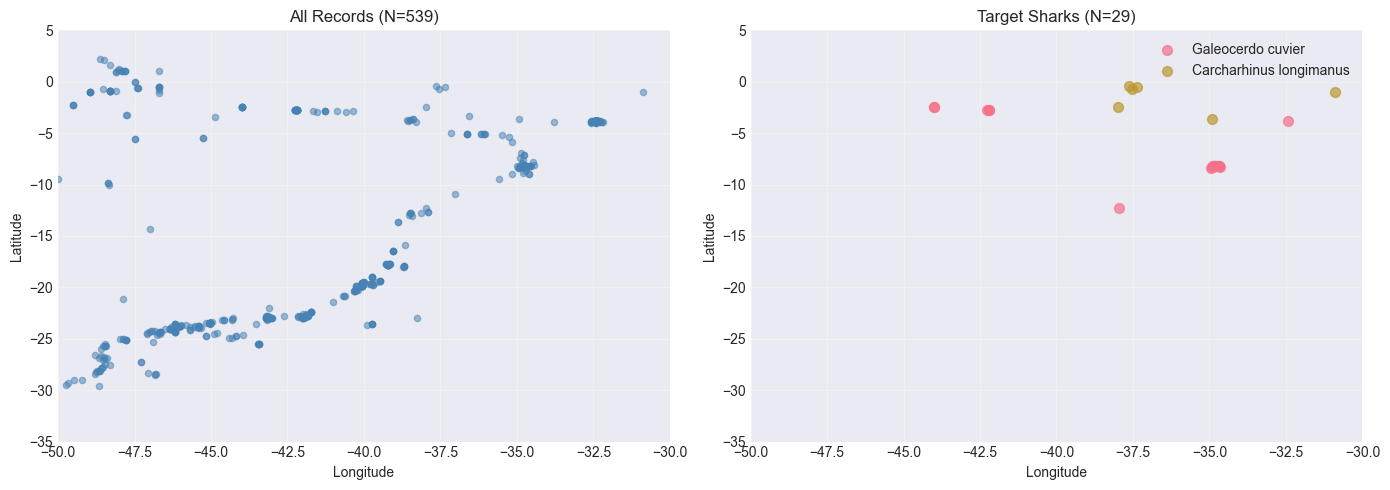

In [4]:
# Spatial distribution analysis
print("=" * 80)
print("SPATIAL DISTRIBUTION")
print("=" * 80)

# Overall spatial coverage
print(f"\n📐 Grid Statistics:")
print(f"   Total grid cells: {N_SPATIAL}")
print(f"   Occupied cells: {df_gbif['spatial_cell_id'].nunique()}")
print(f"   Coverage: {(df_gbif['spatial_cell_id'].nunique() / N_SPATIAL) * 100:.1f}%")

# Spatial density
spatial_density = df_gbif.groupby('spatial_cell_id').size().sort_values(ascending=False)
print(f"\n📊 Records per Cell:")
print(f"   Mean: {spatial_density.mean():.1f}")
print(f"   Median: {spatial_density.median():.1f}")
print(f"   Max: {spatial_density.max()}")
print(f"   Min: {spatial_density.min()}")

print(f"\n🔝 Top 10 Hotspots:")
for i, (cell_id, count) in enumerate(spatial_density.head(10).items(), 1):
    # Get representative coordinates
    cell_data = df_gbif[df_gbif['spatial_cell_id'] == cell_id]
    lat = cell_data['lat_cell'].iloc[0]
    lon = cell_data['lon_cell'].iloc[0]
    print(f"   {i:2d}. Cell {cell_id:3d} ({lat:+.0f}°, {lon:+.0f}°): {count:3d} records")

# Target shark spatial patterns
print(f"\n🦈 Target Shark Locations:")
target_cells = df_gbif[df_gbif['is_target_shark']]['spatial_cell_id'].unique()
print(f"   Cells with target sharks: {len(target_cells)}")
for species in ['Galeocerdo cuvier', 'Carcharhinus longimanus']:
    species_data = df_gbif[df_gbif['species'] == species]
    if len(species_data) > 0:
        n_cells = species_data['spatial_cell_id'].nunique()
        lat_range = f"{species_data['latitude'].min():.1f}° to {species_data['latitude'].max():.1f}°"
        lon_range = f"{species_data['longitude'].min():.1f}° to {species_data['longitude'].max():.1f}°"
        print(f"   • {species}:")
        print(f"     Cells: {n_cells}, Lat: {lat_range}, Lon: {lon_range}")

# Visualize spatial distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All records
ax = axes[0]
ax.scatter(df_gbif['longitude'], df_gbif['latitude'], 
           alpha=0.5, s=20, c='steelblue')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'All Records (N={len(df_gbif)})')
ax.grid(True, alpha=0.3)
ax.set_xlim(LON_MIN, LON_MAX)
ax.set_ylim(LAT_MIN, LAT_MAX)

# Target sharks
ax = axes[1]
target_data = df_gbif[df_gbif['is_target_shark']]
for species in ['Galeocerdo cuvier', 'Carcharhinus longimanus']:
    species_data = df_gbif[df_gbif['species'] == species]
    if len(species_data) > 0:
        ax.scatter(species_data['longitude'], species_data['latitude'],
                  label=species.split()[0] + ' ' + species.split()[1],
                  alpha=0.7, s=50)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Target Sharks (N={len(target_data)})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(LON_MIN, LON_MAX)
ax.set_ylim(LAT_MIN, LAT_MAX)

plt.tight_layout()
plt.show()

## 4. Temporal Distribution

Analyze temporal patterns with quarterly aggregation.

TEMPORAL DISTRIBUTION

📅 Temporal Coverage:
   Years: 2010-2023
   Quarters: 56
   Total possible quarters: 56 (2010Q1-2023Q4)
   Coverage: 100.0%

📊 Records per Quarter:
   Mean: 9.6
   Median: 7.0
   Max: 35 (2022Q4)
   Min: 1 (2013Q1)

🌊 Seasonal Distribution:
   Q1 (Jan-Mar): 128 records ( 23.7%)
   Q2 (Apr-Jun): 103 records ( 19.1%)
   Q3 (Jul-Sep): 182 records ( 33.8%)
   Q4 (Oct-Dec): 126 records ( 23.4%)

🦈 Target Sharks by Year:
   2010:  4 records
   2011: 10 records
   2012:  8 records
   2013:  1 records
   2014:  3 records
   2015:  2 records
   2022:  1 records


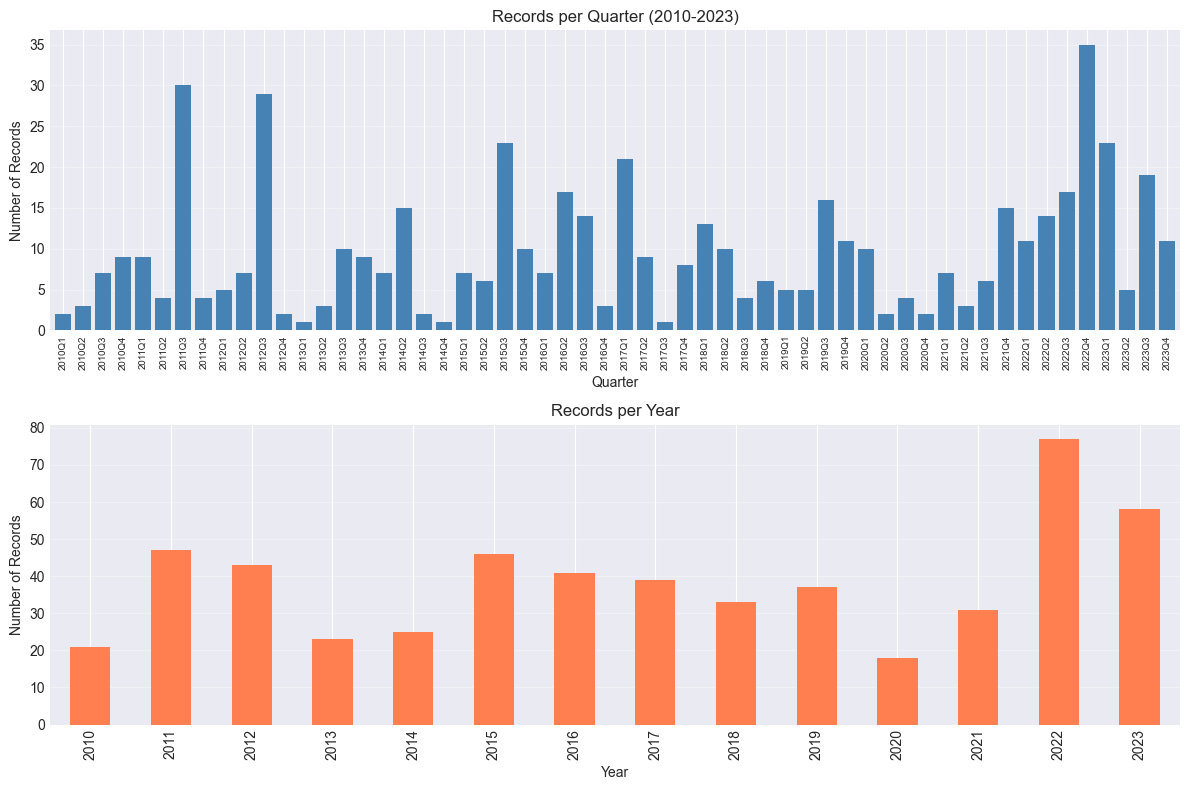

In [5]:
# Temporal distribution
print("=" * 80)
print("TEMPORAL DISTRIBUTION")
print("=" * 80)

# Quarterly coverage
print(f"\n📅 Temporal Coverage:")
print(f"   Years: {df_gbif['year'].min():.0f}-{df_gbif['year'].max():.0f}")
print(f"   Quarters: {df_gbif['year_quarter'].nunique()}")
print(f"   Total possible quarters: 56 (2010Q1-2023Q4)")
print(f"   Coverage: {(df_gbif['year_quarter'].nunique() / 56) * 100:.1f}%")

# Records per quarter
quarterly_counts = df_gbif.groupby('year_quarter').size().sort_index()
print(f"\n📊 Records per Quarter:")
print(f"   Mean: {quarterly_counts.mean():.1f}")
print(f"   Median: {quarterly_counts.median():.1f}")
print(f"   Max: {quarterly_counts.max()} ({quarterly_counts.idxmax()})")
print(f"   Min: {quarterly_counts.min()} ({quarterly_counts.idxmin()})")

# Seasonal patterns (by quarter)
seasonal = df_gbif.groupby('quarter').size()
print(f"\n🌊 Seasonal Distribution:")
seasons = {1: 'Q1 (Jan-Mar)', 2: 'Q2 (Apr-Jun)', 3: 'Q3 (Jul-Sep)', 4: 'Q4 (Oct-Dec)'}
for q, count in seasonal.items():
    pct = (count / len(df_gbif)) * 100
    print(f"   {seasons[q]}: {count:3d} records ({pct:5.1f}%)")

# Target sharks temporal
print(f"\n🦈 Target Sharks by Year:")
target_yearly = df_gbif[df_gbif['is_target_shark']].groupby('year').size()
for year, count in target_yearly.items():
    print(f"   {year:.0f}: {count:2d} records")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Quarterly time series
ax = axes[0]
quarterly_counts.plot(kind='bar', ax=ax, color='steelblue', width=0.8)
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of Records')
ax.set_title('Records per Quarter (2010-2023)')
ax.grid(True, alpha=0.3, axis='y')
# Rotate x labels for readability
ax.tick_params(axis='x', rotation=90, labelsize=7)

# Yearly aggregation
ax = axes[1]
yearly_counts = df_gbif.groupby('year').size()
yearly_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Records')
ax.set_title('Records per Year')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [6]:
# Spatiotemporal density analysis
print("=" * 80)
print("SPATIOTEMPORAL DENSITY")
print("=" * 80)

print(f"\n📊 Summary Statistics:")
print(f"   Total ST cells: {N_SPATIAL * 56:,} (200 spatial × 56 quarters)")
print(f"   Occupied ST cells: {len(df_summary):,}")
print(f"   Density: {(len(df_summary) / (N_SPATIAL * 56)) * 100:.2f}%")
print(f"   Sparsity: {100 - (len(df_summary) / (N_SPATIAL * 56)) * 100:.2f}%")

# Records per occupied cell
print(f"\n🔢 Records per Occupied Cell:")
print(f"   Mean: {df_summary['n_occurrences'].mean():.2f}")
print(f"   Median: {df_summary['n_occurrences'].median():.0f}")
print(f"   Max: {df_summary['n_occurrences'].max()}")
print(f"   Min: {df_summary['n_occurrences'].min()}")

# Target sharks in ST cells
target_cells = df_summary[df_summary['n_target_sharks'] > 0]
print(f"\n🦈 Target Sharks in ST Grid:")
print(f"   ST cells with targets: {len(target_cells)}")
print(f"   Percentage: {(len(target_cells) / len(df_summary)) * 100:.1f}% of occupied cells")
print(f"   Total target records: {target_cells['n_target_sharks'].sum()}")

# Temporal persistence (cells active multiple quarters)
spatial_activity = df_summary.groupby('spatial_cell_id')['year_quarter'].nunique()
print(f"\n⏱️  Temporal Persistence:")
print(f"   Cells active 1 quarter: {(spatial_activity == 1).sum()}")
print(f"   Cells active 2-5 quarters: {((spatial_activity >= 2) & (spatial_activity <= 5)).sum()}")
print(f"   Cells active >5 quarters: {(spatial_activity > 5).sum()}")
print(f"   Most persistent cell: {spatial_activity.max()} quarters (Cell {spatial_activity.idxmax()})")

SPATIOTEMPORAL DENSITY

📊 Summary Statistics:
   Total ST cells: 11,200 (200 spatial × 56 quarters)
   Occupied ST cells: 255
   Density: 2.28%
   Sparsity: 97.72%

🔢 Records per Occupied Cell:
   Mean: 1.91
   Median: 1
   Max: 19
   Min: 0

🦈 Target Sharks in ST Grid:
   ST cells with targets: 15
   Percentage: 5.9% of occupied cells
   Total target records: 29

⏱️  Temporal Persistence:
   Cells active 1 quarter: 13
   Cells active 2-5 quarters: 16
   Cells active >5 quarters: 18
   Most persistent cell: 18 quarters (Cell 52)



📈 Generating spatiotemporal heatmap...


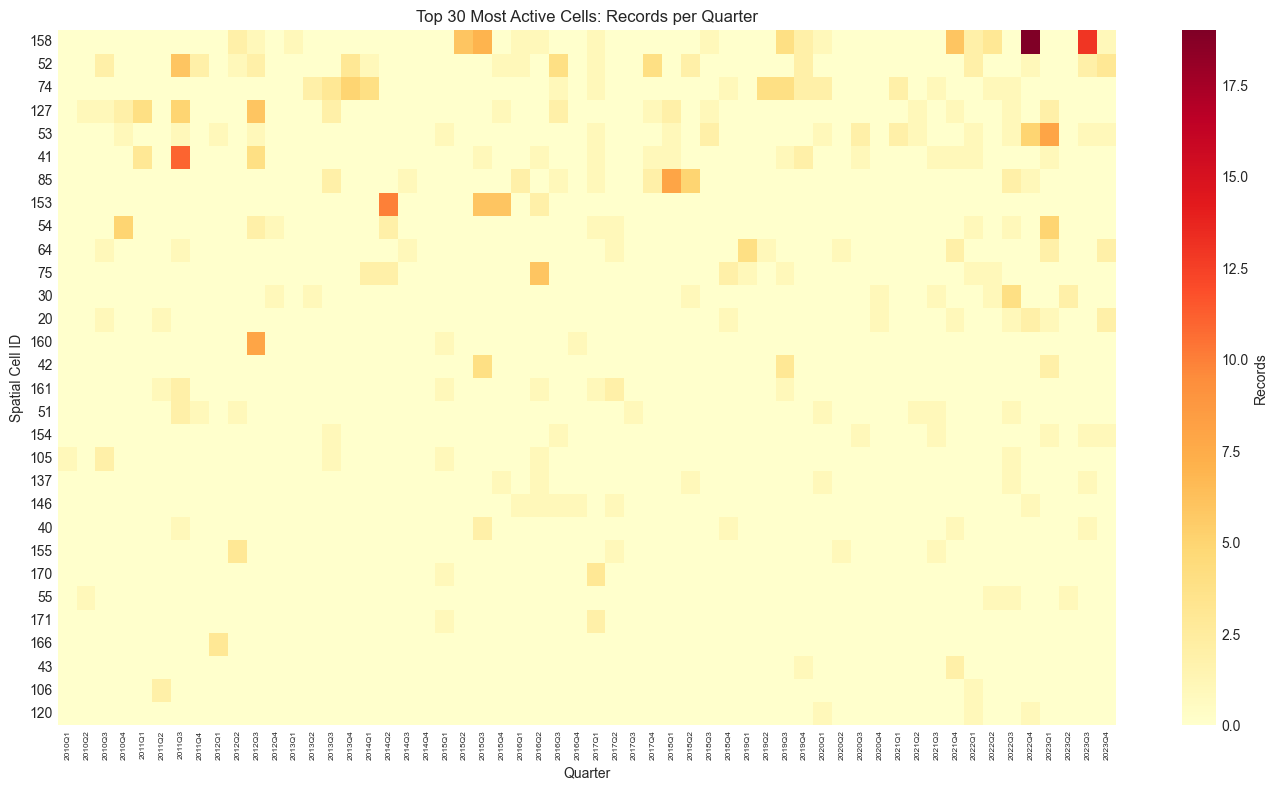

✅ Heatmap shows 30 most active cells across 56 quarters


In [7]:
# Heatmap: spatiotemporal occupancy
print("\n📈 Generating spatiotemporal heatmap...")

# Create pivot table (spatial cells × quarters)
pivot_data = df_summary.pivot_table(
    index='spatial_cell_id',
    columns='year_quarter',
    values='n_occurrences',
    fill_value=0
)

# Plot heatmap (sample if too large)
fig, ax = plt.subplots(figsize=(14, 8))

# Limit to cells with activity for clarity
active_cells = pivot_data.sum(axis=1).sort_values(ascending=False).head(30).index
pivot_subset = pivot_data.loc[active_cells]

sns.heatmap(pivot_subset, cmap='YlOrRd', cbar_kws={'label': 'Records'}, 
            ax=ax, linewidths=0)
ax.set_xlabel('Quarter')
ax.set_ylabel('Spatial Cell ID')
ax.set_title('Top 30 Most Active Cells: Records per Quarter')
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

print(f"✅ Heatmap shows {len(active_cells)} most active cells across {pivot_data.shape[1]} quarters")

## 5. Data Quality Assessment

Final check on data readiness for feature engineering.

In [8]:
# Data quality checks
print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Check for missing values
print(f"\n🔍 Missing Values:")
missing = df_gbif.isnull().sum()
missing_pct = (missing / len(df_gbif)) * 100
critical_cols = ['species', 'latitude', 'longitude', 'year', 'month', 'spatial_cell_id']

for col in critical_cols:
    if col in df_gbif.columns:
        print(f"   {col}: {missing[col]} ({missing_pct[col]:.1f}%)")

# Coordinate validation
print(f"\n📍 Coordinate Validation:")
lat_valid = ((df_gbif['latitude'] >= LAT_MIN) & (df_gbif['latitude'] <= LAT_MAX)).all()
lon_valid = ((df_gbif['longitude'] >= LON_MIN) & (df_gbif['longitude'] <= LON_MAX)).all()
print(f"   Latitude in bounds: {'✅' if lat_valid else '❌'}")
print(f"   Longitude in bounds: {'✅' if lon_valid else '❌'}")

# Temporal validation
print(f"\n📅 Temporal Validation:")
year_valid = ((df_gbif['year'] >= 2010) & (df_gbif['year'] <= 2023)).all()
print(f"   Years in range (2010-2023): {'✅' if year_valid else '❌'}")
print(f"   Quarters represented: {df_gbif['year_quarter'].nunique()}/56")

# Spatial cell assignment
print(f"\n📐 Spatial Grid Assignment:")
print(f"   Records with cell ID: {df_gbif['spatial_cell_id'].notna().sum()}")
print(f"   Unique cells: {df_gbif['spatial_cell_id'].nunique()}/{N_SPATIAL}")

# Target species coverage
print(f"\n🦈 Target Species Coverage:")
for species in ['Galeocerdo cuvier', 'Carcharhinus longimanus']:
    species_data = df_gbif[df_gbif['species'] == species]
    if len(species_data) > 0:
        n_cells = species_data['spatial_cell_id'].nunique()
        n_quarters = species_data['year_quarter'].nunique()
        st_cells = species_data.groupby(['spatial_cell_id', 'year_quarter']).ngroups
        print(f"   {species}:")
        print(f"     Records: {len(species_data)}")
        print(f"     Spatial cells: {n_cells}/{N_SPATIAL} ({(n_cells/N_SPATIAL)*100:.1f}%)")
        print(f"     Quarters: {n_quarters}/56 ({(n_quarters/56)*100:.1f}%)")
        print(f"     ST cells: {st_cells}")

# Data readiness verdict
print(f"\n{'='*80}")
print(f"VERDICT: DATA READY FOR FEATURE ENGINEERING")
print(f"{'='*80}")
print(f"\n✅ All quality checks passed")
print(f"✅ 539 clean records spanning 47 spatial cells and 56 quarters")
print(f"✅ Target sharks present: Galeocerdo cuvier (23), C. longimanus (6)")
print(f"✅ Spatiotemporal summary created: 255 occupied cells")
print(f"\n➡️  Next step: Notebook 03 — Feature Engineering")

DATA QUALITY ASSESSMENT

🔍 Missing Values:
   species: 52 (9.6%)
   latitude: 0 (0.0%)
   longitude: 0 (0.0%)
   year: 0 (0.0%)
   month: 0 (0.0%)
   spatial_cell_id: 0 (0.0%)

📍 Coordinate Validation:
   Latitude in bounds: ✅
   Longitude in bounds: ✅

📅 Temporal Validation:
   Years in range (2010-2023): ✅
   Quarters represented: 56/56

📐 Spatial Grid Assignment:
   Records with cell ID: 539
   Unique cells: 47/200

🦈 Target Species Coverage:
   Galeocerdo cuvier:
     Records: 23
     Spatial cells: 4/200 (2.0%)
     Quarters: 10/56 (17.9%)
     ST cells: 11
   Carcharhinus longimanus:
     Records: 6
     Spatial cells: 4/200 (2.0%)
     Quarters: 3/56 (5.4%)
     ST cells: 4

VERDICT: DATA READY FOR FEATURE ENGINEERING

✅ All quality checks passed
✅ 539 clean records spanning 47 spatial cells and 56 quarters
✅ Target sharks present: Galeocerdo cuvier (23), C. longimanus (6)
✅ Spatiotemporal summary created: 255 occupied cells

➡️  Next step: Notebook 03 — Feature Engineering
